In [363]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data

In [364]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=2)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1)])
H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])


$$
H = -0.5 \cdot Z_0 - 0.5 \cdot Z_1 
$$

$$
= -0.5 \cdot (Z \otimes I) - 0.5 \cdot (I \otimes Z)
$$

$$

$$


$$
where,
Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$

In [365]:
# Global Parameters
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   # Dephase tau
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

$$
Let, e^{-t/T_2} = e^{-\tau} \\[1em]

\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}

=

\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$

$$
\\[1em]
Then,
\quad \gamma = 
1 - e^{-2 \tau}
$$

$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

In [366]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    tau_1 = Paras_global[1]
    tau_2 = Paras_global[2]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(torch.pi/2, wires=0)
    qml.RY(torch.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    

    qml.RY(-torch.pi/2, wires = 0)    
    qml.RY(-torch.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    
    qml.RY(torch.pi/2, wires = 0)    
    qml.RY(torch.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.RX(torch.pi/(2), wires=0)
    qml.RX(torch.pi/(2), wires=1)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1])

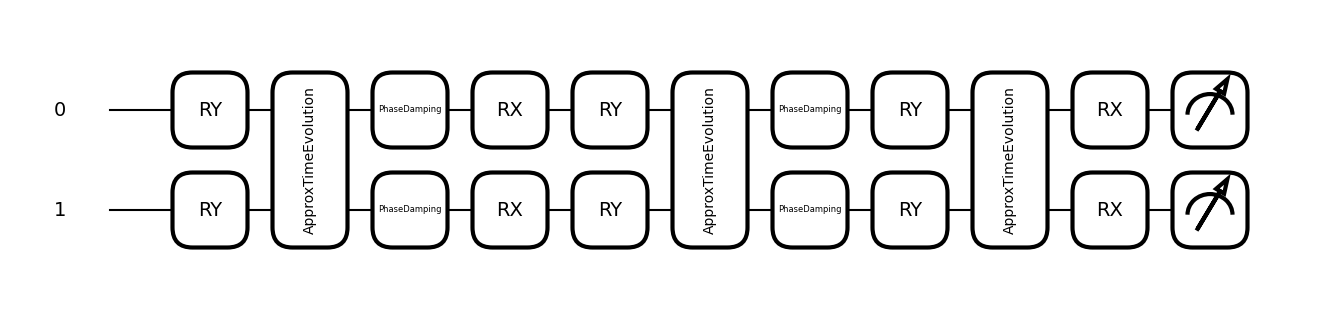

In [367]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [368]:
sweep_range = torch.arange(0, 3*torch.pi, 1e-1)
Paras_global = torch.tensor([2.35, torch.pi/2, torch.pi/2], dtype=torch.float)
tau_dephase = 0

Data = np.zeros((len(sweep_range), 2))
Data[:, 0] = sweep_range
for idx, phi_cur in enumerate(sweep_range):
    Data[idx][1] = qml.qinfo.classical_fisher(circuit)(phi_cur)
    
Data

array([[0.00000000e+00, 3.84589310e-24],
       [1.00000001e-01, 3.98465743e+00],
       [2.00000003e-01, 3.99611448e+00],
       [3.00000012e-01, 3.99824230e+00],
       [4.00000006e-01, 3.99898769e+00],
       [5.00000000e-01, 3.99933131e+00],
       [6.00000024e-01, 3.99951802e+00],
       [6.99999988e-01, 3.99962962e+00],
       [8.00000012e-01, 3.99970045e+00],
       [9.00000036e-01, 3.99974861e+00],
       [1.00000000e+00, 3.99978247e+00],
       [1.10000002e+00, 3.99980636e+00],
       [1.20000005e+00, 3.99982289e+00],
       [1.30000007e+00, 3.99983394e+00],
       [1.39999998e+00, 3.99984144e+00],
       [1.50000000e+00, 3.99984594e+00],
       [1.60000002e+00, 3.99984585e+00],
       [1.70000005e+00, 3.99984298e+00],
       [1.80000007e+00, 3.99983728e+00],
       [1.89999998e+00, 3.99982854e+00],
       [2.00000000e+00, 3.99981309e+00],
       [2.10000014e+00, 3.99979300e+00],
       [2.20000005e+00, 3.99976484e+00],
       [2.29999995e+00, 3.99972375e+00],
       [2.400000

In [369]:
# @qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
# def Post_selection(phi):

#     global Paras_global, Gamma_ps_global
#     get_density_matrix = circuit(phi)
        
#     # Kraus operator for 2*2 matrix
#     K = torch.tensor([
#         [torch.sqrt(1 - Gamma_ps_global), 0], 
#         [0, 1]
#     ], dtype=torch.complex128)
    
#     Numerator = torch.kron(K, torch.eye(2)) @ get_density_matrix @ torch.kron(K, torch.eye(2)).conj().T
#     Denominator = torch.trace(Numerator)
    
#     rho_ps = Numerator / Denominator
    
#     qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
#     return qml.density_matrix(wires = [0, 1])  

In [370]:
@qml.qnode(dev, interface = 'torch', diff_method = 'backprop')
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=torch.complex128)
    
    Numerator = torch.kron(K, K) @ get_density_matrix @ torch.kron(K, K).conj().T
    Denominator = torch.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1])
    
    return qml.density_matrix(wires = [0, 1])  

$$ 
K =  \begin{bmatrix}
\sqrt{1-\gamma_{ps}} & 0 \\
0 & 1 
\end{bmatrix}  
$$


$$
\rho_{ps} = 
\frac{(K \otimes K) \rho (K \otimes K)^{\dagger}}
% (K^{\dagger} \otimes I ^{\dagger})}

{Tr[(K \otimes K) \rho (K \otimes K)^{\dagger}]}
$$

In [371]:
sweep_range = torch.arange(0, 3*torch.pi, 1e-1)
Paras_global = torch.tensor([2.35, torch.pi/2, torch.pi/2], dtype=torch.float)
Gamma_ps_global = torch.tensor([0.8])

Data = np.zeros((len(sweep_range), 2))
Data[:, 0] = sweep_range
for idx, phi_cur in enumerate(sweep_range):
    Data[idx][1] = qml.qinfo.classical_fisher(Post_selection)(phi_cur)
    
Data

array([[0.00000000e+00, 1.85780854e-23],
       [1.00000001e-01, 1.00362302e+01],
       [2.00000003e-01, 9.19121784e+00],
       [3.00000012e-01, 8.00192974e+00],
       [4.00000006e-01, 6.73286874e+00],
       [5.00000000e-01, 5.55791773e+00],
       [6.00000024e-01, 4.55971382e+00],
       [6.99999988e-01, 3.75538200e+00],
       [8.00000012e-01, 3.12782241e+00],
       [9.00000036e-01, 2.64784723e+00],
       [1.00000000e+00, 2.28588522e+00],
       [1.10000002e+00, 2.01673745e+00],
       [1.20000005e+00, 1.82073309e+00],
       [1.30000007e+00, 1.68338105e+00],
       [1.39999998e+00, 1.59459112e+00],
       [1.50000000e+00, 1.54791982e+00],
       [1.60000002e+00, 1.54001804e+00],
       [1.70000005e+00, 1.57032104e+00],
       [1.80000007e+00, 1.64099744e+00],
       [1.89999998e+00, 1.75714999e+00],
       [2.00000000e+00, 1.92727043e+00],
       [2.10000014e+00, 2.16391912e+00],
       [2.20000005e+00, 2.48453047e+00],
       [2.29999995e+00, 2.91202396e+00],
       [2.400000

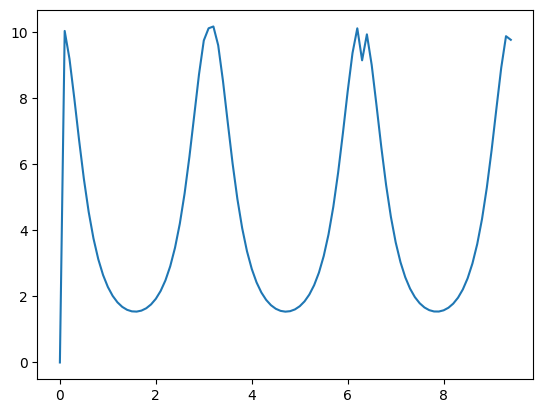

In [374]:
plt.plot(Data[:,0], Data[:, 1])